In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os
import random
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3,MobileNetV2
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, BatchNormalization,Dropout,Input,Average

In [2]:
data_dir =r"E:\1. Thesis\Update_Code\Dataset"
keyword= ['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']

In [3]:
class_folders=os.listdir(data_dir)
image_paths=[]
labels=[]

for class_folder in class_folders:
    for key in keyword:
        if key in class_folder:
                class_path=os.path.join(data_dir,class_folder)
                image_files=os.listdir(class_path)
                for image_file in image_files:
                    image_path=os.path.join(class_path,image_file)
                    image_paths.append(image_path)
                    labels.append(class_folder)
    
df=pd.DataFrame({'image_path':image_paths,'label':labels})
print("The classes:",np.unique(df['label']))

class_counts=df['label'].value_counts()
class_counts

The classes: ['Anthracnose' 'Bacterial Canker' 'Cutting Weevil' 'Die Back' 'Gall Midge'
 'Healthy' 'Powdery Mildew' 'Sooty Mould']


label
Anthracnose         500
Bacterial Canker    500
Cutting Weevil      500
Die Back            500
Gall Midge          500
Healthy             500
Powdery Mildew      500
Sooty Mould         500
Name: count, dtype: int64

In [4]:
#split train(60%) and the rest(40%)
train_df, rest_df = train_test_split(df,test_size=0.4, random_state=42)

#split valiidation(50%) and test(50%)
val_df, test_df = train_test_split(rest_df, test_size=0.5, random_state=42)

In [5]:
def load_images_for_cnn(train_df, 
                        val_df, 
                        test_df, 
                        batch_size=32, 
                        target_size=(224,224)):

    train_datagen=ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
    )
    train_generator=train_datagen.flow_from_dataframe(
        train_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    validation_datagen=ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_dataframe(
        val_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    test_datagen=ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(
        test_df,
        x_col='image_path',
        y_col='label',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    return train_generator,validation_generator,test_generator

train_generator,validation_generator,test_generator=load_images_for_cnn(train_df,
                                                                        val_df, 
                                                                        test_df, 
                                                                        batch_size=32, 
                                                                        target_size=(224,224))

Found 2400 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.


In [6]:
# Load Models
model_path1 = r"E:\1. Thesis\Update_Code\SavedModel\InceptionV3F.hdf5"
m1 = load_model(model_path1)
m1 = Model(inputs=m1.input, outputs=m1.output, name='InceptionV3')  # Use `.input` and `.output`

model_path2 = r"E:\1. Thesis\Update_Code\SavedModel\DenseNet1213F.hdf5"
m2 = load_model(model_path2)
m2 = Model(inputs=m2.input, outputs=m2.output, name='DenseNet121')

# Ensemble Model
model_input = Input(shape=(224,224,3), name="ensemble_input")
m1_output = m1(model_input)
m2_output = m2(model_input)

ensemble_output = Average()([m1_output, m2_output])  # Corrected: Ensure tensor inputs

ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

# Compile Model
ensemble_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])


In [7]:
# Train Model
epochs = 10
training_history = ensemble_model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

C:\Users\Sanzida\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 614s 8s/step - accuracy: 0.9673 - loss: 0.2957 - val_accuracy: 0.9625 - val_loss: 0.2439
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 546s 7s/step - accuracy: 0.9711 - loss: 0.2548 - val_accuracy: 0.9613 - val_loss: 0.2204
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 561s 7s/step - accuracy: 0.9653 - loss: 0.2404 - val_accuracy: 0.9613 - val_loss: 0.2013
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 544s 7s/step - accuracy: 0.9734 - loss: 0.2188 - val_accuracy: 0.9663 - val_loss: 0.1839
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 538s 7s/step - accuracy: 0.9730 - loss: 0.1908 - val_accuracy: 0.9700 - val_loss: 0.1668
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 541s 7s/step - accuracy: 0.9770 - loss: 0.1784 - val_accuracy: 0.9725 - val_loss: 0.1551
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 528s 7s/step - accuracy: 0.9743 - loss: 0.1775 - val_accuracy: 0.9725 - val_loss: 0.1467
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 518s 7s/step - accuracy: 0.9803 - loss: 0.1611 - val_accuracy: 0.9737 - v

In [11]:
test_loss,test_accuracy=ensemble_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 131s 5s/step - accuracy: 0.9787 - loss: 0.1332
Test Loss: 0.13872148096561432, Test Accuracy: 0.9750000238418579


In [12]:
predictions=ensemble_model.predict(test_generator)
predicted_classes=np.argmax(predictions,axis=1)
ture_classes=test_generator.classes
class_labels=['Anthracnose','Bacterial Canker','Cutting Weevil','Die Back','Gall Midge','Healthy','Powdery Mildew','Sooty Mould']
report=metrics.classification_report(ture_classes,predicted_classes,target_names=class_labels)
print(report)

25/25 ━━━━━━━━━━━━━━━━━━━━ 151s 5s/step
                  precision    recall  f1-score   support

     Anthracnose       0.97      0.97      0.97       117
Bacterial Canker       0.99      0.99      0.99       109
  Cutting Weevil       1.00      1.00      1.00       104
        Die Back       0.99      0.99      0.99        97
      Gall Midge       0.99      0.94      0.97       107
         Healthy       0.93      1.00      0.96        77
  Powdery Mildew       1.00      0.94      0.97        98
     Sooty Mould       0.93      0.98      0.95        91

        accuracy                           0.97       800
       macro avg       0.97      0.98      0.97       800
    weighted avg       0.98      0.97      0.98       800



In [15]:
test_predictions=ensemble_model.predict(test_generator)
trst_predicted_labels=np.argmax(test_predictions,axis=1)
test_true_labels=test_generator.classes

25/25 ━━━━━━━━━━━━━━━━━━━━ 152s 6s/step


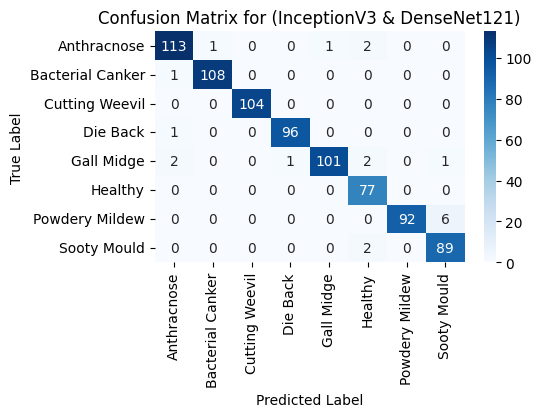

In [16]:
plt.figure(figsize=(5,3))
conf_matrix=confusion_matrix(test_true_labels,trst_predicted_labels)
class_names=[label for label in np.unique(df['label'])]
seaborn.heatmap(conf_matrix,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for (InceptionV3 & DenseNet121)')
plt.show()

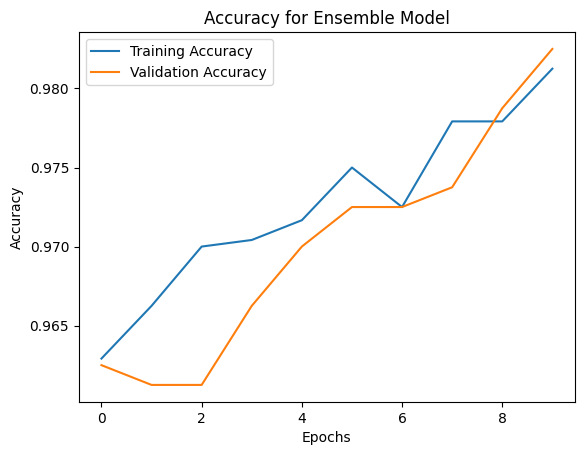

In [17]:
#plot training and validation accuracy
plt.plot(training_history.history['accuracy'],label='Training Accuracy')
plt.plot(training_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy for Ensemble Model')
plt.legend()
plt.show()

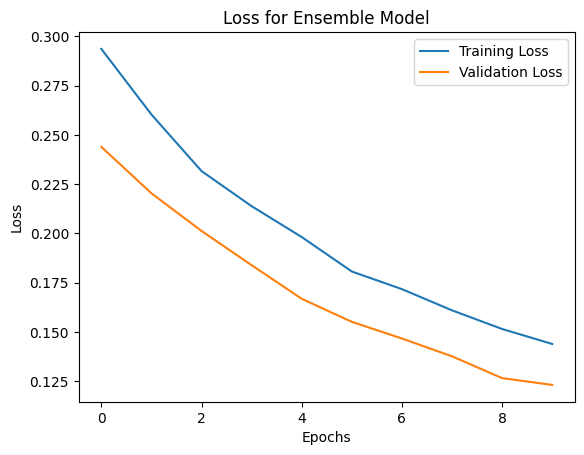

In [18]:
#plot training and validation loss
plt.plot(training_history.history['loss'],label='Training Loss')
plt.plot(training_history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss for Ensemble Model')
plt.legend()
plt.show()

In [19]:
ensemble_model.save(r'E:\1. Thesis\Update_Code\SavedModel\InceptionV3&DenseNet121.hdf5')